# Lab 8 
### Andrik Solano Jiménez
### Ronald Arce Matamoros

Análisis del problema:
Para este problema se desea clasificar si hay o no tatuaje en la imagen , por lo cual se debera realizar un algoritmo de deep learning de redes convolucionales para averiguarlo.

In [67]:
import os
import random
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg  
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')

## Entendimiento de los datos

### Visualizacion de los datos

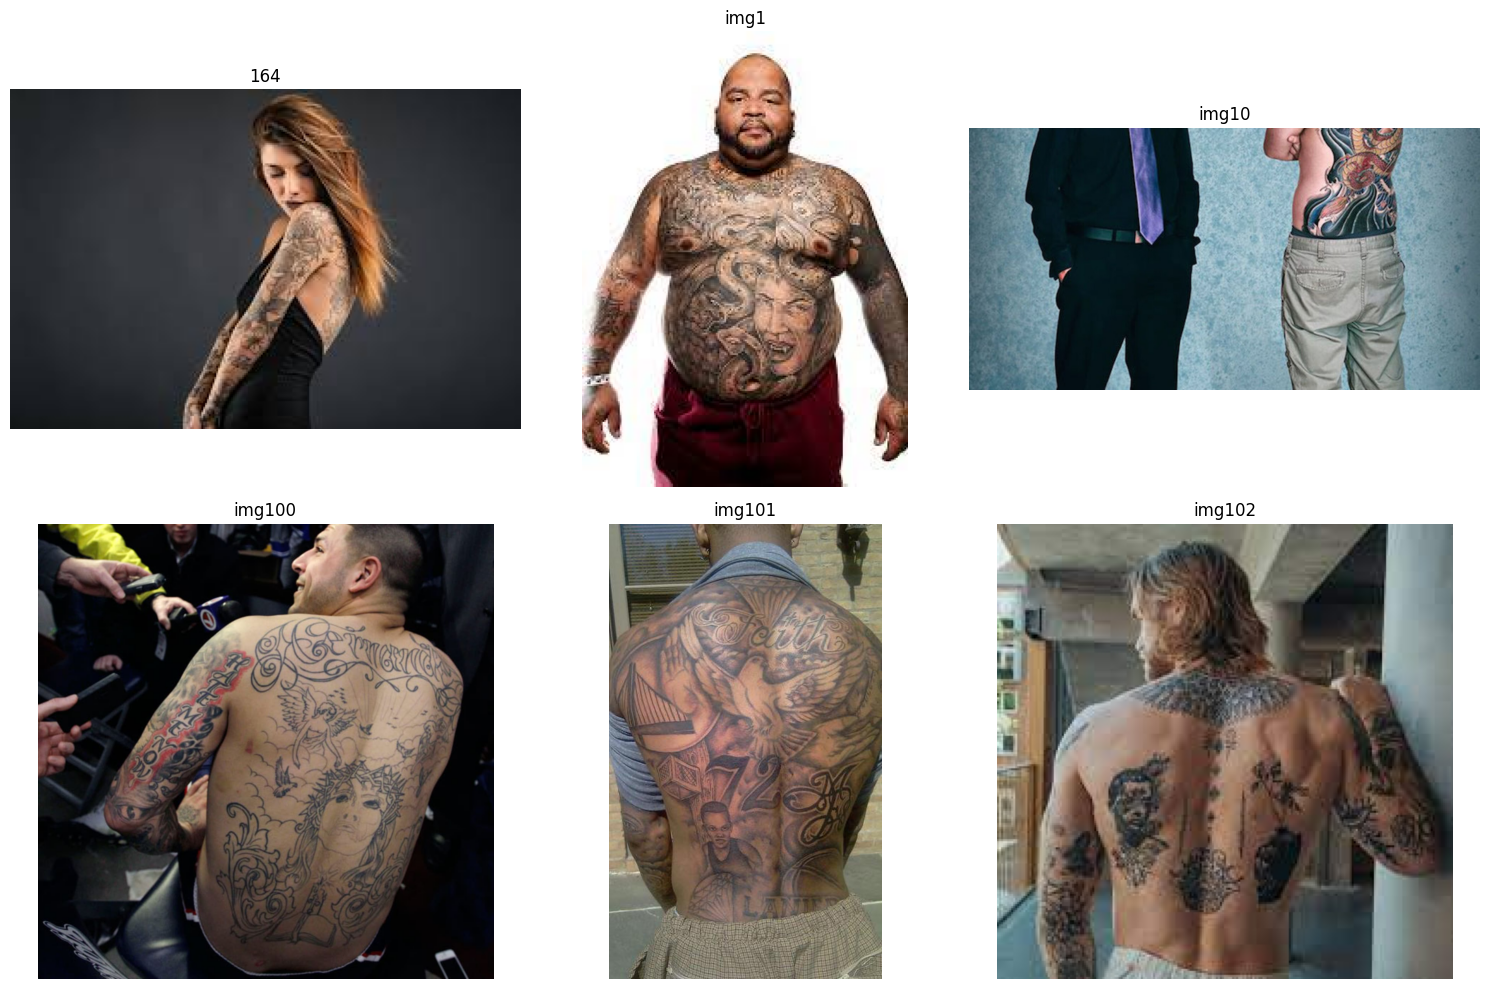

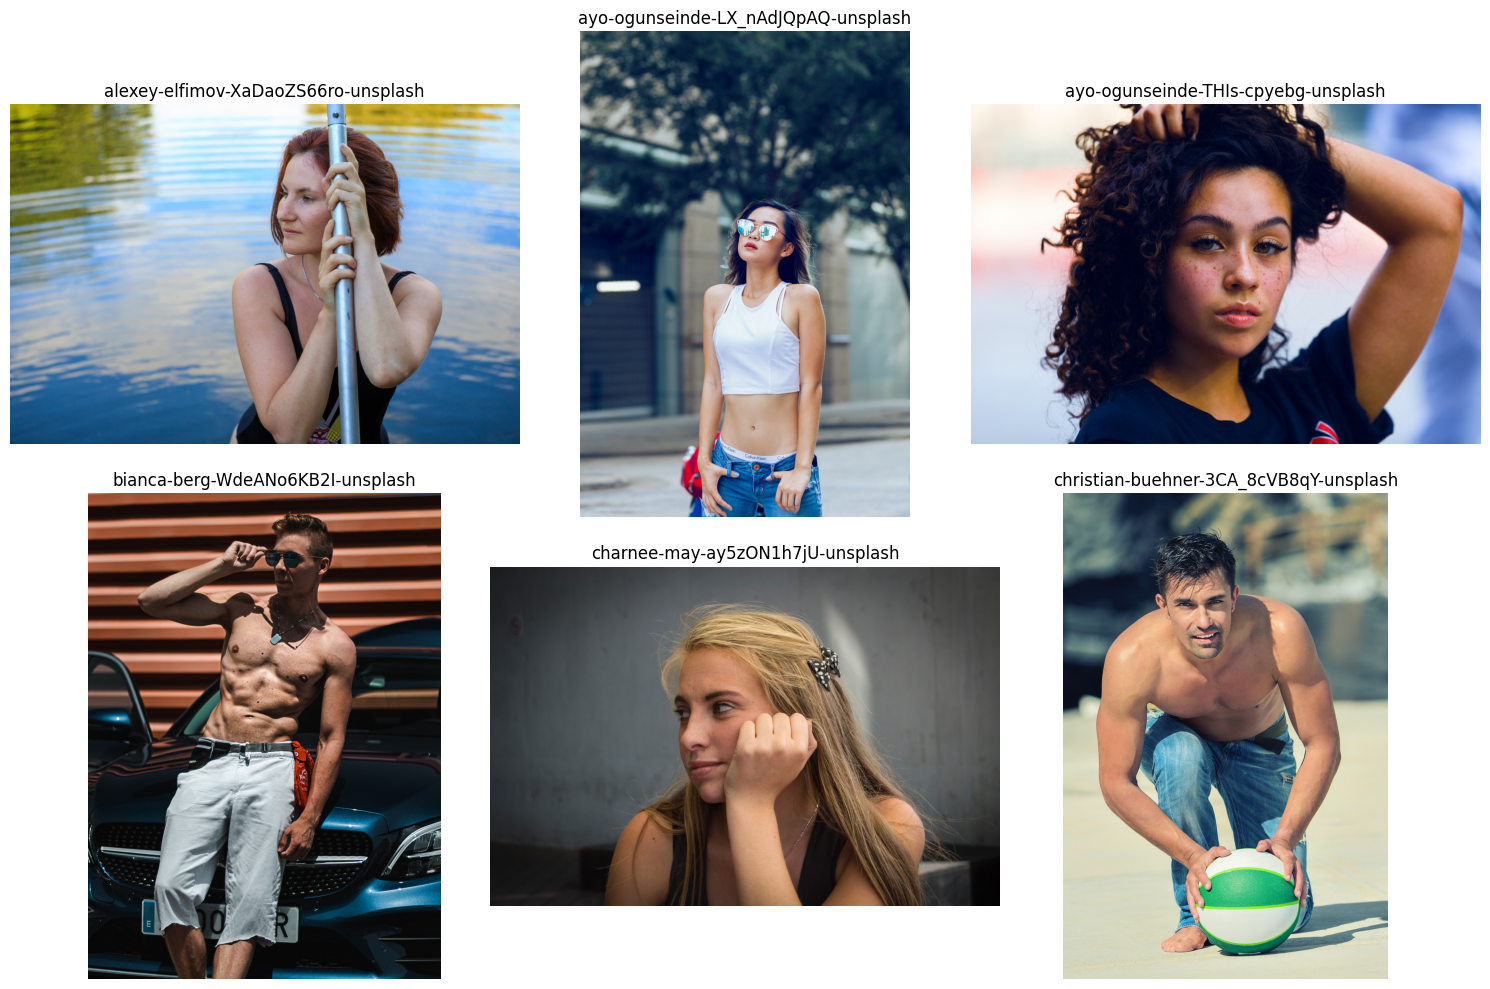

In [68]:
def display_images_with_labels(path, num_images=6):
    # Get a list of all image file names in the directory
    image_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    
    # Display the images with their labels
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    for i in range(min(num_images, len(image_files))):
        # Get the image file name and its label
        image_file = image_files[i]
        label = image_file.split('.')[0]

        # Load and display the image
        img_path = os.path.join(path, image_file)
        img = mpimg.imread(img_path)
        ax = axs[i // 3, i % 3]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(label)

    plt.tight_layout()
    plt.show()


path = "./data/withTatto"
display_images_with_labels(path)

path = "./data/withoutTatto"
display_images_with_labels(path)

## Carga y procesamiento de los datos

In [69]:
batch_size = 10
img_height = 100
img_width = 100

In [70]:
# Crear el generador de datos con aumento y normalización
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalización de las imágenes
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    './data',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    './data',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 325 images belonging to 2 classes.
Found 81 images belonging to 2 classes.


In [71]:
# Obtener los nombres de las clases
class_names = list(train_generator.class_indices.keys())
print(class_names)

['withTatto', 'withoutTatto']


In [72]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

## Modelo Deep Learning

In [73]:
# Compilar el modelo
num_classes = 2

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  
])

In [74]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
#Punto de guardado
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

# Compilar el modelo
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',  # Cambiado a binary_crossentropy
              metrics=['accuracy'])



history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
33/33 [==============================] - 6s 156ms/step - loss: 1.1642 - accuracy: 0.6185 - val_loss: 0.7021 - val_accuracy: 0.4691
Epoch 2/100
33/33 [==============================] - 4s 132ms/step - loss: 0.9807 - accuracy: 0.6677 - val_loss: 0.9482 - val_accuracy: 0.4691
Epoch 3/100
33/33 [==============================] - 4s 133ms/step - loss: 0.8327 - accuracy: 0.6031 - val_loss: 1.3088 - val_accuracy: 0.4691
Epoch 4/100
33/33 [==============================] - 4s 131ms/step - loss: 0.6880 - accuracy: 0.6892 - val_loss: 1.5209 - val_accuracy: 0.4691
Epoch 5/100
33/33 [==============================] - 4s 135ms/step - loss: 0.5701 - accuracy: 0.7600 - val_loss: 1.2364 - val_accuracy: 0.4691
Epoch 6/100
33/33 [==============================] - 4s 133ms/step - loss: 0.6448 - accuracy: 0.6985 - val_loss: 1.5673 - val_accuracy: 0.4691
Epoch 7/100
33/33 [==============================] - 4s 137ms/step - loss: 0.6493 - accuracy: 0.6985 - val_loss: 1.0846 - val_accuracy: 0.5309

## Evaluacion

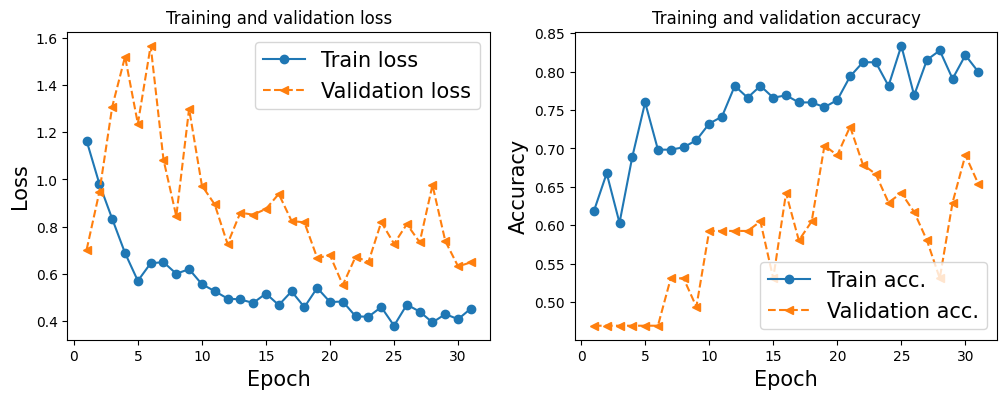

In [75]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_title("Training and validation loss")
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.set_title("Training and validation accuracy")
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)


plt.show()

In [76]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(validation_generator)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

9/9 [==============================] - 1s 136ms/step - loss: 0.7376 - accuracy: 0.6420
Test Loss: 0.7376071214675903
Test Accuracy: 0.6419752836227417


1/1 [==============================] - 0s 27ms/step


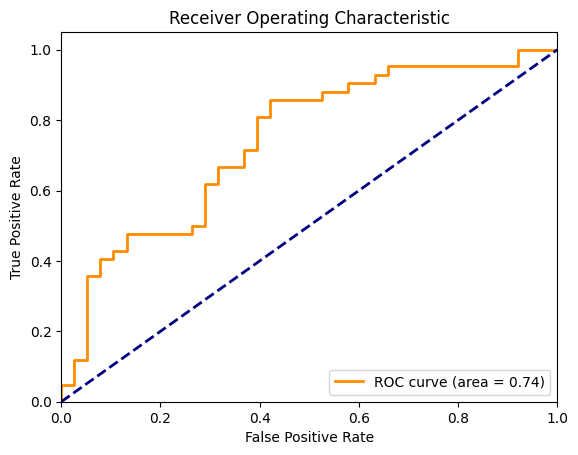

In [77]:
from sklearn.metrics import roc_curve, auc
# Obtener el número de pasos para recorrer completamente el conjunto de validación
validation_steps = validation_generator.samples // validation_generator.batch_size

# Inicializar listas para etiquetas verdaderas y probabilidades predichas
true_labels = []
predicted_probabilities = []

# Iterar sobre el generador de validación
for _ in range(validation_steps):
    images, labels = next(validation_generator)
    true_labels.extend(labels)  # Agregar las etiquetas verdaderas a la lista
    predicted_probabilities.extend(model.predict(images).ravel())  # Agregar las probabilidades predichas

true_labels = np.array(true_labels)
predicted_probabilities = np.array(predicted_probabilities)

# Si las etiquetas son codificadas one-hot, convierte a la forma unidimensional
if len(true_labels.shape) > 1:
    true_labels = np.argmax(true_labels, axis=1)

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)  # Usar las probabilidades predichas directamente
roc_auc = auc(fpr, tpr)

# Plotear la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Resultados

Aunque el modelo ha alcanzado una precisión aceptable en el conjunto de prueba, con un valor de aproximadamente 0.64, la pérdida asociada al mismo es relativamente alta, rondando alrededor de 0.74. Esto sugiere que el modelo puede estar teniendo dificultades para generalizar y podría estar experimentando cierto grado de sobreajuste. A pesar de los ajustes realizados en la arquitectura del modelo, el aumento de datos y la regularización, es posible que existan características intrínsecas en el conjunto de datos que requieran una mayor complejidad para ser capturadas de manera efectiva. Sería beneficioso explorar en mayor profundidad la naturaleza de los datos y considerar técnicas adicionales de preprocesamiento, ajuste de hiperparámetros y posiblemente, la exploración de modelos más avanzados para mejorar aún más el rendimiento y la capacidad de generalización del modelo en futuros desarrollos.